En este cuaderno se va a estudiar la presencia del efecto batch en los datos, ya que provienen de diversos estudios diferentes, por lo que podrían haber sesgos técnicos. Para ello, vamos a empezar cargando los datos

In [32]:
import pandas as pd

# Leer el archivo ignorando líneas que empiezan por #
counts_df = pd.read_csv("SL4_counts_scaled.txt", sep='\t', comment='#')

# Verificar las primeras filas
counts_df.head()

,Geneid,Chr,Start,End,Strand,Length,ERR14096487,ERR14096488,ERR14096489,SRR19735893,...,SRR26436269,SRR26436270,SRR26436271,SRR26436275,SRR26436276,SRR26436277,SRR32302926,SRR32302927,SRR32302928,SRR32302929
0,gene:Solyc00g500001.1,SL4.0ch00,93750,94430,+,681,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,gene:Solyc00g500002.1,SL4.0ch00,305442,306257,-,816,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,gene:Solyc00g500003.1,SL4.0ch00;SL4.0ch00;SL4.0ch00;SL4.0ch00;SL4.0ch00;SL4.0ch00,311496;330270;344080;347298;351799;381867,311570;330628;344133;347428;352644;382066,-;-;-;-;-;-,1665,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,gene:Solyc00g500004.1,SL4.0ch00;SL4.0ch00,417592;417794,417723;418482,+;+,821,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,gene:Solyc00g500005.1,SL4.0ch00,478389,478640,+,252,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ahora, teniendo el dataframe del conteo cargado, se necesitan los metadatos de las muestras para conseguir información relacionada como el estudio al que pertenecen cada una, y así poder estudiar el posible efecto batch presente.

In [3]:
path = r"C:\Users\Trvpe\Documents\METADATA_SRA.xlsx"
df = pd.read_excel(path)
df.head()


,Extracted_SRR_ID,SAMPLE INFORMATION,STRESS,STUDY
0,SRR26436257,Sample: salinity + heat stress [S+HS-3],S + H,1
1,SRR26436258,Sample: salinity + heat stress [S+HS-2],S + H,1
2,SRR26436259,Sample: salinity + heat stress [S+HS-2],S + H,1
3,SRR26436263,Sample: heat stress [HS-3],H,1
4,SRR26436264,Sample: heat stress [HS-3],H,1


Este archivo contiene la información sobre el ID de la muestra, de qué se trata cada muestra, a que estrés está relacionada, y a que estudio de los 6 diferentes pertenece.
Vamos a ver de qué diferentes tipos de estrés se tienen datos y hacer el recuento de cada uno de ellos.

In [4]:
# Recuento de muestras por tipo de estrés
df['STRESS'] = df['STRESS'].str.strip()
conteo_estres = df['STRESS'].value_counts(dropna=False)
conteo_estres




STRESS
control    7
S          6
H          5
S + H      3
D          3
Al         3
CL         1
Name: count, dtype: int64

En total hay 28 muestras de las cuales: 7 muestras control, 5 muestras de estrés por calor (Heat stress:H), 6 muestras estrés salino (Salt stress:S), 3 muestras de la combinación del estrés salino y el estrés por calor (S + H), 3 muestras del estrés por sequía (Drought stress:D), 3 muestras de estrés alcalino (Alkaline stress:Al) y 1 muestra de estrés por frío (Cold stress:Cl).
Visualizar con un plot para hacer resumen:





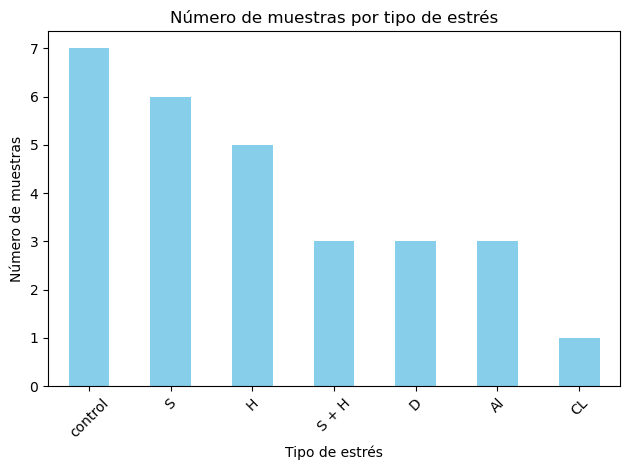

In [5]:
import matplotlib.pyplot as plt

conteo_estres.plot(kind='bar', color='skyblue')
plt.title("Número de muestras por tipo de estrés")
plt.xlabel("Tipo de estrés")
plt.ylabel("Número de muestras")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("recuento_estres.png", dpi=300)
plt.show()




Ya con el conteo en un dataframe y los metadatos en otro, se puede comenzar a estudiar el efecto batch.

Para ello, se ha procedido a preparar los datos para su análisis con scanpy, creando un objeto AnnData a partir de la matriz de expresión normalizada (TPMs), donde las filas corresponden a muestras y las columnas a genes. Además, se ha incorporado la información de metadatos asociada a cada muestra.

In [13]:
import scanpy as sc

counts_T = counts_df.iloc[:, 6:].T
# Crear objeto AnnData
adata = sc.AnnData(X=counts_T.values)
adata.obs_names = counts_T.index
adata.var_names = counts_T.columns

In [14]:
metadata = df.set_index("Extracted_SRR_ID")
adata.obs = metadata.loc[adata.obs_names]

Se ha aplicado una transformación logarítmica para estabilizar la varianza. Finalmente, los datos fueron escalados y se realizó un análisis de componentes principales (PCA) para comprobar la existencia de agrupaciones.

C:\Users\Trvpe\anaconda3\Lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


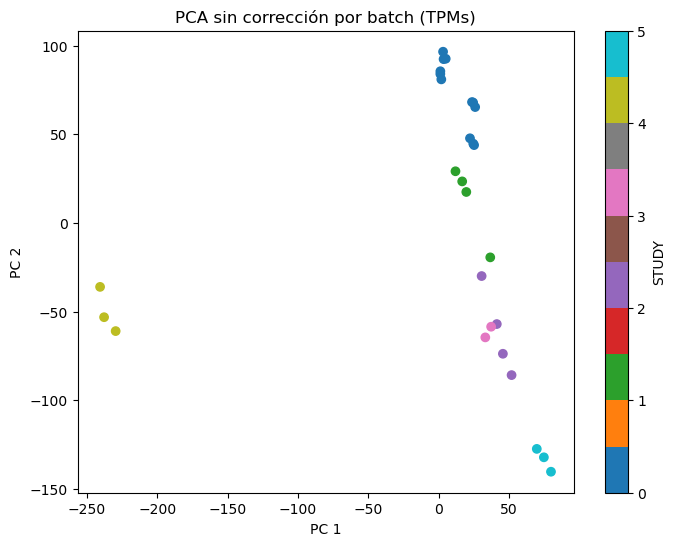

In [15]:
adata_raw = adata.copy()
sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
sc.tl.pca(adata_raw, svd_solver='arpack')

# Visualizar PCA
adata_raw.obs['STUDY'] = adata_raw.obs['STUDY'].astype('category')
study_codes = adata_raw.obs['STUDY'].cat.codes

plt.figure(figsize=(8, 6))
plt.scatter(adata_raw.obsm['X_pca'][:, 0], adata_raw.obsm['X_pca'][:, 1], c=study_codes, cmap='tab10')
plt.title("PCA sin corrección por batch (TPMs)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(label='STUDY')
plt.savefig("PCA_batch_TPMs.png")
plt.show()

En el PCA se identifica claramente una agrupación por estudio, lo que podría implicar la existencia de sesgos técnicos. Por ello, se va a llevar a cabo la correción de este efecto.

Found 5282 genes with zero variance.
Found 5282 genes with zero variance.


C:\Users\Trvpe\anaconda3\Lib\site-packages\scanpy\preprocessing\_combat.py:347: RuntimeWarning: invalid value encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
C:\Users\Trvpe\anaconda3\Lib\site-packages\scanpy\preprocessing\_combat.py:347: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
C:\Users\Trvpe\anaconda3\Lib\site-packages\scanpy\preprocessing\_combat.py:347: RuntimeWarning: invalid value encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
C:\Users\Trvpe\anaconda3\Lib\site-packages\scanpy\preprocessing\_combat.py:347: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


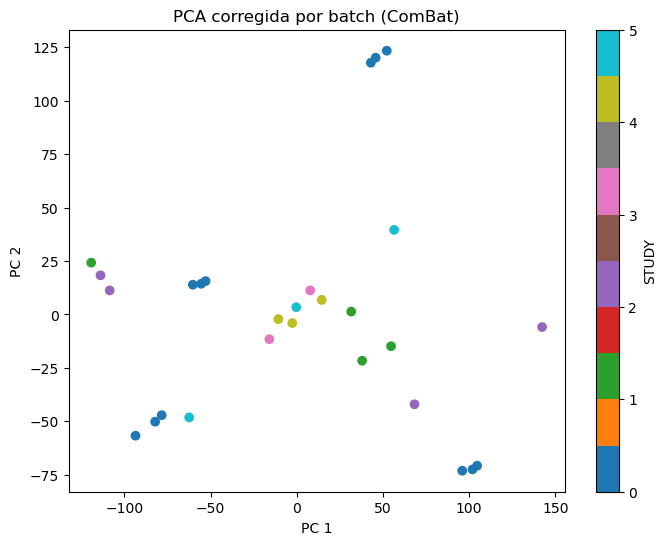

In [16]:
# Aplicar combat para la corrección del efecto batch
adata_combat = adata_raw.copy()
sc.pp.combat(adata_combat, key='STUDY')

# Visualizar el PCA
sc.pp.combat(adata_combat, key='STUDY')
sc.pp.scale(adata_combat)
sc.tl.pca(adata_combat, svd_solver='arpack')
study_codes = adata_combat.obs['STUDY'].cat.codes
plt.figure(figsize=(8, 6))
plt.scatter(adata_combat.obsm['X_pca'][:, 0], adata_combat.obsm['X_pca'][:, 1], c=study_codes, cmap='tab10')
plt.title("PCA corregida por batch (ComBat)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(label='STUDY')
plt.savefig("PCA_batch_corrected_ComBat.png")
plt.show()



ComBat ha sido efectivo en reducir el efecto batch. Aunque hay agrupamientos residuales, la mezcla entre estudios es considerablemente mejor.

In [27]:
ad = adata_combat.X
adata_df = pd.DataFrame(ad, columns=adata.var_names)
adata_df

,0,1,2,3,4,5,6,7,8,9,...,34065,34066,34067,34068,34069,34070,34071,34072,34073,34074
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.093361,0.0,...,-0.863718,1.399650,-0.058093,0.004583,-0.897134,1.733657,-0.018745,0.502155,0.0,-0.093361
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.093361,0.0,...,0.398847,-1.105440,-0.058093,-0.964686,-0.236881,-0.911571,-0.018745,-1.788918,0.0,-0.093361
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.093361,0.0,...,0.741737,-1.250783,-0.058093,0.979561,1.243285,0.452352,-0.018745,0.641289,0.0,-0.093361
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.898591,0.0,...,0.829890,0.879528,0.367416,1.107116,1.145374,-0.651525,-0.018745,0.924156,0.0,4.936437
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.936437,0.0,...,-0.584926,-0.480700,0.247375,0.898396,0.834533,-0.727252,-0.018745,-0.233436,0.0,-0.898591
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.898591,0.0,...,0.902563,-0.930216,0.448851,-1.173091,-0.932768,1.235227,-0.018745,-1.756907,0.0,-0.898591
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.898591,0.0,...,-0.921899,0.545389,-1.542584,-1.233212,-1.118824,0.009299,-0.018745,-0.936032,0.0,-0.898591
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.093361,0.0,...,0.315209,-0.315297,-0.058093,-0.944923,0.823831,-0.833964,-0.018745,-0.670673,0.0,-0.093361
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.093361,0.0,...,-0.306929,0.304348,-0.058093,0.778361,-1.126845,0.728839,-0.018745,0.528211,0.0,-0.093361
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.093361,0.0,...,0.002963,0.956190,4.495131,-0.977974,-1.202190,-0.640717,-0.018745,-0.530036,0.0,-0.093361


In [31]:
adata_df_transposed = adata_df.T
gene_info = counts_df.iloc[:, :6]
new_df = pd.concat([gene_info, adata_df_transposed], axis=1)
new_df.to_csv("SL4_counts_combat.csv", index=False)

